# UCI Dataset: Air Quality

**Dataset Homepage:** https://archive.ics.uci.edu/dataset/360/air+quality

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-7s4giphluwgta).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cfc-tsf-algo-v1-2"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

Matplotlib is building the font cache; this may take a moment.


### 2. Data preparation

Load and prepare the data.

In [3]:
# load the data
dataset = pd.read_excel(
    "AirQualityUCI.xlsx",
    usecols=["Date", "Time", "CO(GT)"],
)

# format the time stamps and replace the missing values with NaN
dataset = pd.DataFrame({
    "ts": pd.to_datetime(
        dataset["Date"].dt.strftime("%Y-%m-%d") + " " + dataset["Time"].astype(str),
        format="%Y-%m-%d %H:%M:%S"
    ),
    "y": dataset["CO(GT)"].replace(-200, np.nan)
})

# drop the missing values
dataset.dropna(inplace=True, ignore_index=True)

# calculate the time spans
dataset["ts"] = dataset["ts"].diff().dt.total_seconds().fillna(value=0) / (60 * 60)

In [4]:
dataset.shape

(7674, 2)

In [5]:
dataset.head()

,ts,y
0,0.0,2.6
1,1.0,2.0
2,1.0,2.2
3,1.0,2.2
4,1.0,1.6


In [6]:
dataset.tail()

,ts,y
7669,1.0,3.1
7670,1.0,2.4
7671,1.0,2.4
7672,1.0,2.1
7673,1.0,2.2


In [7]:
dataset["ts"].describe()

count    7674.000000
mean        1.219182
std         4.229401
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       174.000000
Name: ts, dtype: float64

In [8]:
dataset["y"].describe()

count    7674.000000
mean        2.152750
std         1.453252
min         0.100000
25%         1.100000
50%         1.800000
75%         2.900000
max        11.900000
Name: y, dtype: float64

Visualize the data.

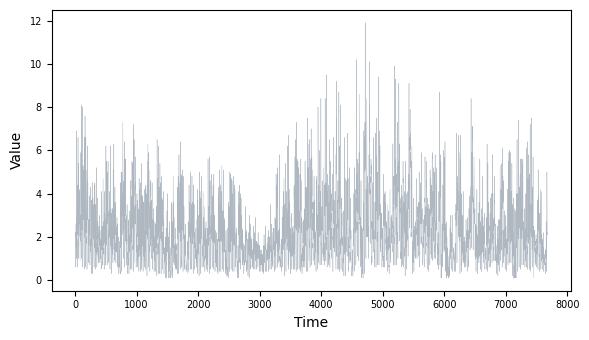

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(dataset["y"], color="#AFB8C1", lw=0.3)
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Split the data.

In [10]:
# number of time steps used as input
context_length = 48

# number of time steps to output
prediction_length = 24

# number of time steps used for testing
cutoff = 30 * 24

# training set
training_dataset = dataset.iloc[:- cutoff]

# test set
test_dataset = dataset.iloc[- cutoff - context_length:]

Upload the data to S3.

In [11]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="AirQuality_train.csv"
)

In [12]:
training_data

's3://sagemaker-eu-west-1-661670223746/AirQuality_train.csv'

In [13]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False),
    bucket=bucket,
    key="AirQuality_test.csv"
)

In [14]:
test_data

's3://sagemaker-eu-west-1-661670223746/AirQuality_test.csv'

### 3. Training

Fit the model to the training set.

In [15]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": context_length,
        "prediction-length": prediction_length,
        "backbone-layers": 1,
        "backbone-units": 128,
        "backbone-activation": "silu",
        "backbone-dropout": 0,
        "hidden-size": 64,
        "minimal": 0,
        "no-gate": 0,
        "use-ltc": 0,
        "use-mixed": 0,
        "lr": 0.001,
        "lr-decay": 0.9,
        "batch-size": 64,
        "epochs": 100,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-algo-v1-2-2023-09-08-18-51-45-324


2023-09-08 18:51:45 Starting - Starting the training job...
2023-09-08 18:51:59 Starting - Preparing the instances for training......
2023-09-08 18:52:52 Downloading - Downloading input data............
2023-09-08 18:55:03 Training - Downloading the training image.........
2023-09-08 18:56:28 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-08 18:57:03,870 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-08 18:57:03,871 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-08 18:57:03,871 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-08 18:57:03,871 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value silu to Json.
Returning the value itself
2023-09-08 18:57:03,880 sagema

### 4. Inference

Generate the test set predictions.

In [16]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: cfc-tsf-algo-v1-2-2023-09-08-19-06-43-505


................

INFO:sagemaker:Creating model with name: cfc-tsf-algo-v1-2-2023-09-08-19-06-43-5-2023-09-08-19-08-04-109


INFO:sagemaker:Creating transform job with name: cfc-tsf-algo-v1-2-2023-09-08-19-08-04-846


2023-09-08T19:15:13,277 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-08T19:15:13,342 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-08T19:15:13,439 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Metrics address: http://127.0.0.1:8082
Model Store: /.sagemaker/ts/models
Initial Models: model=/opt/ml/model
Log dir: /logs
Metrics dir: /logs
Netty thread

Load the test set predictions from S3.

In [17]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/AirQuality_test.csv.out"
)

predictions = pd.DataFrame(
    data=predictions.split("\n")[1:-1],
    columns=predictions.split("\n")[:1]
).replace('""', np.nan).astype(float)

In [18]:
predictions.shape

(792, 1)

In [19]:
predictions.head()

,y
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [20]:
predictions.tail()

,y
787,2.702807
788,2.462340
789,2.221536
790,2.291478
791,2.189827


Visualize the test set predictions.

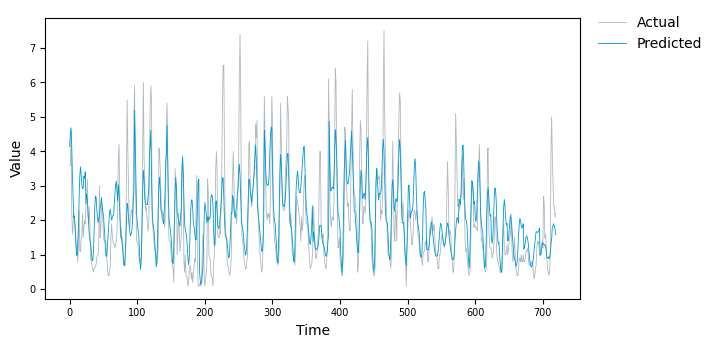

In [21]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(test_dataset["y"].iloc[context_length:].values, color="#AFB8C1", lw=0.6, label="Actual")
ax.plot(predictions["y"].iloc[context_length: - prediction_length].values, color="#009ad3", lw=0.6, label="Predicted")
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(frameon=False, bbox_to_anchor=(1.2, 1, 0, 0))
fig.tight_layout()
fig.show()

Calculate the error metrics.

In [22]:
mse = mean_squared_error(
    test_dataset["y"].iloc[context_length:],
    predictions["y"].iloc[context_length: - prediction_length]
)

mae = mean_absolute_error(
    test_dataset["y"].iloc[context_length:],
    predictions["y"].iloc[context_length: - prediction_length]
)

print(f"MSE: {format(mse, '.2f')}, MAE: {format(mae, '.2f')}")

MSE: 0.93, MAE: 0.71
